In [1]:
%load_ext autoreload
%autoreload 2

# Santander Customer Transaction Prediction

## General Information

The Kaggle competition site can be found [here](https://www.kaggle.com/c/santander-customer-transaction-prediction).

## Importing python packages

We will use the common SciPy stack, `numpy`, `pandas`, `scikit-learn`, etc.

In [11]:
from IPython.display import Markdown, display

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import pandas as pd

import sklearn as sk
from sklearn import decomposition

## Configuration

Set some common `matplotlib` preferences:

In [3]:
%matplotlib inline
plt.style.use("ggplot")
mpl.rcParams["figure.figsize"] = (8, 8)

## Importing the dataset

Read the `.csv` files, but apply the columns of the large dataset to the small train dataset, as it does not include column headers.

In [4]:
train_large = pd.read_csv("data/train.csv")
test_large = pd.read_csv("data/test.csv")

test_small = pd.read_csv("data/test_small.csv")
train_small = pd.read_csv(
    "data/train_small.csv",
    names=train_large.columns,
    header=None,
    index_col=False,
)

# EDA

Let's start by checking if the small training set is a proper subset of the large training set.

In [5]:
assert len(train_large.merge(train_small)) == len(train_small)

Yes, it is. Therefore, if we conclude that the large dataset does not contain duplicates, null values, etc., the same conclusion should hold for the small training set. We will use this fact in order to draw conclusions for both datasets in a lot of cases.

## What data do we have?

What columns do we actually have?

In [6]:
train_large.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

And what datatypes are they?

In [7]:
train_large.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

The `ID_code` is probobaly an unique identifier for each row.

In [8]:
train_large.ID_code.is_unique

True

Yes, it is in fact an unique string, here are examples for both datasets.

In [9]:
train_large.ID_code[0:5], train_small.ID_code[0:5]

(0    train_0
 1    train_1
 2    train_2
 3    train_3
 4    train_4
 Name: ID_code, dtype: object, 0    train_1
 1    train_2
 2    train_4
 3    train_5
 4    train_6
 Name: ID_code, dtype: object)

The `target` column is probably our binary `0`/`1` classification label:

In [10]:
train_large.target.isin([0, 1]).all()

True

Yes, all the values of `target` are `0`/`1` encoded. The remaining columns are features named `var_0`, `var_1`, ..., `var_199`, all of them floating point values, 200 of them to be precise. Let's make sure that this is correct:

In [11]:
features = train_large.columns[2:]
assert len(features) == 200
assert (train_large.dtypes[2:] == "float64").all()

Yes, this is correct. One of the problems with this dataset is that the underlying source of these features are unknown, they are a completely black box. Attaining domain knowledge about these features will therefore be more difficult than if we had known the underlying meaning of these variables.

Before we take a look at the number of observations, it is first nice to look at how many missing values we have in order to make the correct conclusions regarding the "real" size of the dataset.

## Missing values

Let's find out if we have any missing values in the form of `NaN`s.

In [12]:
assert not train_large.isnull().values.any()
assert not test_large.isnull().values.any()
assert not test_small.isnull().values.any()

We have no null values whatsoever in any of the datasets, so we need not concern ourselfes with _missing_ values at the moment.
There is a chance that missing values are not indicated as `NaN`s in the dataset, however, but rather with a placeholder value within the `float64` domain. We will look out for such a possibility in the upcoming EDA to find out if this is the case.

## Size of datasets

Now let's look at how large the datasets are, starting by number of observations.

In [13]:
datasets = {
    "small training": train_small,
    "small test": test_small,
    "large training": train_large,
    "large test": test_large,
}
for name, dataset in datasets.items():
    display(Markdown(f"* The number of observations in the **{name} set** is: **{len(dataset)}**"))

* The number of observations in the **small training set** is: **70057**

* The number of observations in the **small test set** is: **70065**

* The number of observations in the **large training set** is: **200000**

* The number of observations in the **large test set** is: **200000**

We have a 50/50 split of train vs test data, the smaller dataset being 35% of the larger dataset.

## Check covariate vector uniqueness

Since `var_0`, ..., `var_199` are floating point values, it is unlikely that there are non-unique feature vectors in the dataset, but we should make sure anyway, just in case.

In [14]:
train_large.iloc[:, 2:].duplicated(subset=None, keep=False).any()

False

We have no **exact** row duplicates, but remember that we could have extremely identical rows and this test would not capture this. We will come back to this issue.

## Check single covariate uniqueness

How unique are these floating point features when we look at one and one feature at a time?
Let's take a quick look:

In [15]:
unique_large_train = []
unique_small_train = []

for covariate in range(2, 202):
    unique_large_train.append(len(train_large.iloc[:, covariate].drop_duplicates())/len(train_large))
    unique_small_train.append(len(train_small.iloc[:, covariate].drop_duplicates())/len(train_small))
    
unique_large_train = np.array(unique_large_train)
unique_small_train = np.array(unique_small_train)

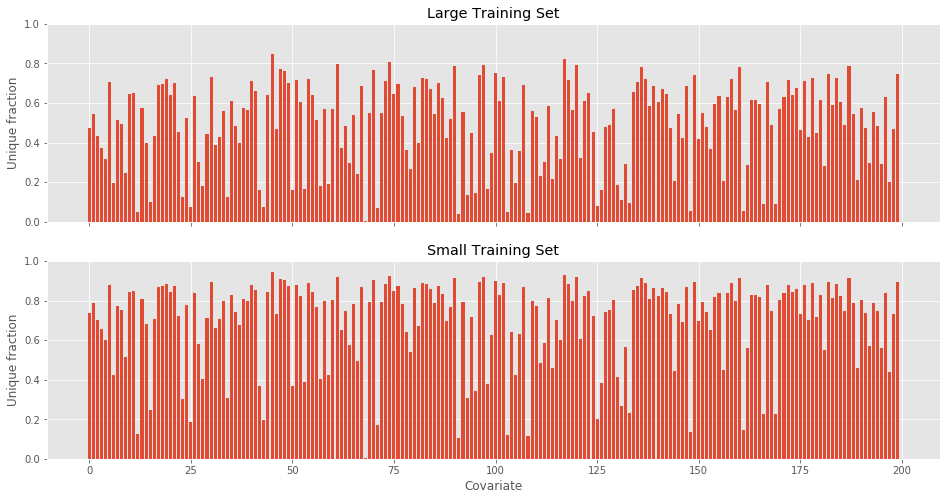

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

ax1.set_title("Large Training Set")
ax2.set_title("Small Training Set");

ax1.set_ylabel("Unique fraction")
ax2.set_ylabel("Unique fraction")
ax2.set_xlabel("Covariate")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

ax1.bar(x=range(0, 200), height=unique_large_train, width=0.75);
ax2.bar(x=range(0, 200), height=unique_small_train, width=0.75);

There is actually a surprising amount of _exact duplication_ column-wise, even when the features are floats. The likelihood for this in a theoretical, continuous, statistical distribution is zero, but in practice (due to data-entry rounding and floating point precision) it is not a too shocking revelation.

Let's investigate this further by plotting the histogram of the least unique covariate besides the histogram of the most unique covariate.

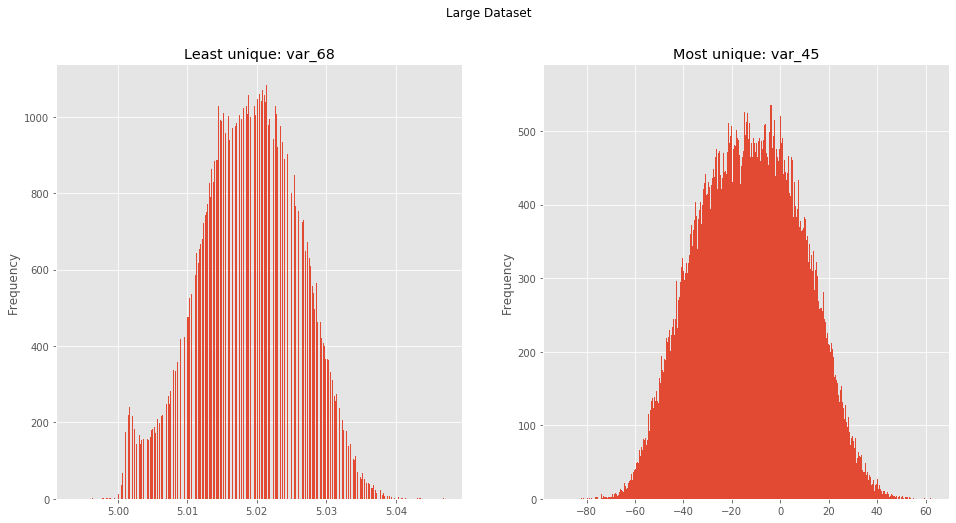

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Large Dataset")

least_unique = np.argmin(unique_large_train)
train_large.iloc[:, least_unique + 2].plot.hist(bins=1000, ax=ax1)
ax1.set_title(f"Least unique: var_{least_unique}")

most_unique = np.argmax(unique_large_train)
train_large.iloc[:, most_unique + 2].plot.hist(bins=1000, ax=ax2)
ax2.set_title(f"Most unique: var_{most_unique}");

We can see that the "non-uniqueness" of `var_68` is not necessarily a problem, the values seem to be somewhat discretized, but it still has a distinct distribution. The same conclusion should hold for the smaller dataset.

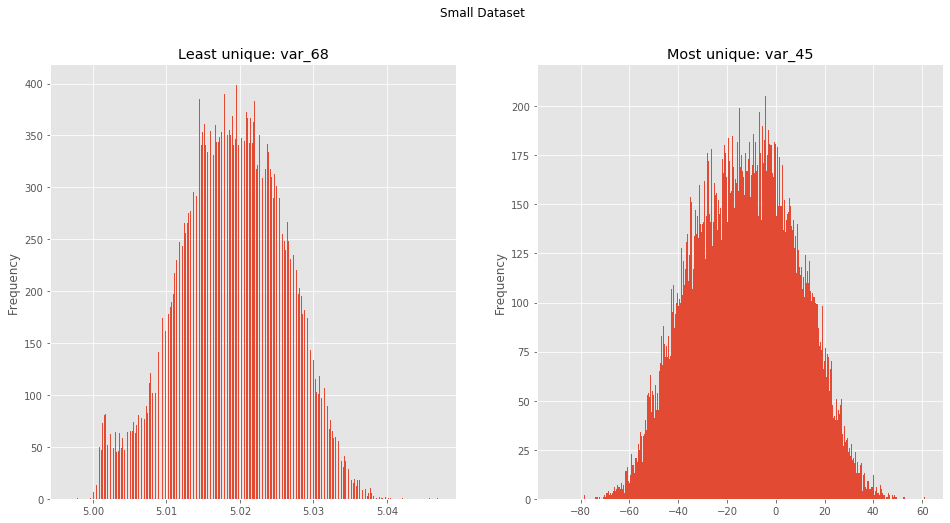

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Small Dataset")

least_unique = np.argmin(unique_small_train)
train_small.iloc[:, least_unique + 2].plot.hist(bins=1000, ax=ax1)
ax1.set_title(f"Least unique: var_{least_unique}")

most_unique = np.argmax(unique_small_train)
train_small.iloc[:, most_unique + 2].plot.hist(bins=1000, ax=ax2)
ax2.set_title(f"Most unique: var_{most_unique}");

Which it does...

We can also observe bell shapes in these histograms, which we will come back to.

## Class Balance

The proportion between `1` and `0` targets is of huge importance for how we tackle the upcoming prediction challenge, so we should take a look at the class (im)balance in the datasets.

In [19]:
for name, dataset in [("Small", train_small), ("Large", train_large)]:
    positives = (dataset.target == 1).sum()
    negatives = len(dataset) - positives
    
    positive_fraction = positives / (positives + negatives)
    negative_fraction = 1 - positive_fraction
    
    display(Markdown(
        f"* **{name} dataset**: "
        f"{100 * negative_fraction:.2f}% negatives, "
        f"{100 * positive_fraction:.2f}% positives"
    ))

* **Small dataset**: 90.03% negatives, 9.97% positives

* **Large dataset**: 89.95% negatives, 10.05% positives

For both datasets, we have a ~ 90/10 split between negatives and positives, respectively. This can definitely be considered as an unbalanced class, which should be kept in mind during model building.

## Normality test

If our features are close to being normally distributed, a whole lot of additional statistical tests becomes available to us, such as the Student T test for instance (for distribution mean calculation tests).

We should therefore check if our features are close to normally distributed.

### Anderson-Darling Test

Let's start by applying the Anderson-Darling Test for normality on the entirety of the large dataset.

In [20]:
from scipy.stats import anderson

def anderson_normality(dataset):
    for feature in features:
        result = anderson(dataset[feature].to_numpy(), dist="norm")
        significance_levels = result.significance_level
        critical_values = result.critical_values
        statistic = result.statistic
        for critical_value, significance in zip(critical_values, significance_levels):
            is_normal = statistic < critical_value
            if is_normal:
                return True
    return False

anderson_normality(dataset=train_large)

False

Not a single feature is considered to be normally distributed even at a 15% significance level!
What about if we group the dataset by `target`?

In [21]:
print(anderson_normality(dataset=train_large[train_large.target == 0]))
print(anderson_normality(dataset=train_large[train_large.target == 1]))

False
False


Still not the case! We should therefore be careful with any normality assumptions going forwards.

## Describing Statistics

We will now take a look at some describing statistics, such as mean, standard deviation, etc..

What is really interesting for our prediction purposes is if these describing statistics differ significantly between observations with negative vs. positive labels.

### Normalized Delta

Let's start by constructing a pseudo-statistic, which we will call normalized delta, defined by

$$
    \Delta_{i} = \frac{|\mu_{i0} - \mu_{i1}|}{\sigma_{i0} \sigma_{i1}}
$$

Where $i$ denotes the feature, $\mu_{ij}$ is the feature mean for response $j$, and $\sigma_{ij}$ is the feature standard deviation for response $j$.
Let's implement this pseudo-statistic and calculate it for all the features. We will then plot the 5 largest and 5 smallest features according to this statistic.

In [22]:
def normalized_delta(dataset):
    mean = dataset.groupby("target").mean()[features]
    delta_mean = (mean.iloc[0,:] - dataset.iloc[1,:]).abs()
    std = dataset.groupby("target").std()[features].product()
    normalized_delta_mean = (delta_mean / std)[features].astype(float)
    return normalized_delta_mean
    

In [23]:
normalized_delta_mean = normalized_delta(dataset=train_large)
sorted_deltas = normalized_delta_mean.sort_values()
largest_deltas = sorted_deltas[-5:]
smallest_deltas = sorted_deltas[:5]

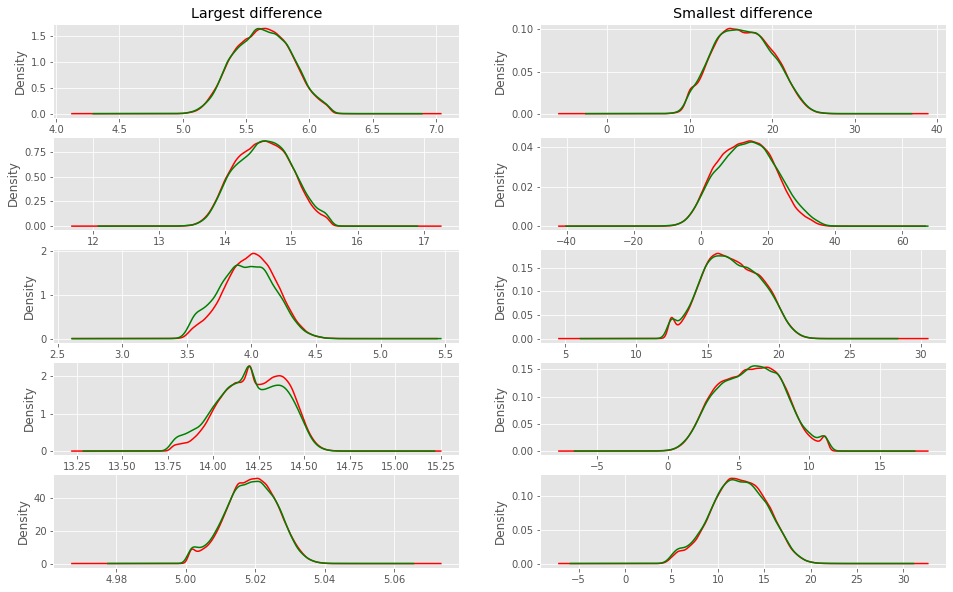

In [24]:
fig, ax = plt.subplots(5, 2, figsize=(16, 10))
ax[0][0].set_title("Largest difference")
ax[0][1].set_title("Smallest difference")

for axes, small, large in zip(ax, smallest_deltas.index, largest_deltas.index):
    train_large[train_large.target == 0][large].plot.density(ax=axes[0], color="red")
    train_large[train_large.target == 1][large].plot.density(ax=axes[0], color="green");
    
    train_large[train_large.target == 0][small].plot.density(ax=axes[1], color="red")
    train_large[train_large.target == 1][small].plot.density(ax=axes[1], color="green");

There is not much to be gleaned from this, besides that there is no really easy wins using the single feature means in isolation in order to seperate positive and negative features.

### Principal Component Analysis

We will now decompose the features into its principal components, using PCA analysis.
If a large amount of the variance is explained by a proper subset of the components, we can use this in order to remove components which do not explain a lot of variance, reducing unecessary complexity in the feature space.

In [25]:
pca = decomposition.PCA()
pca_components = pca.fit_transform(train_large[features])
variance_ratio = pca.explained_variance_ratio_
total_explained = np.cumsum(variance_ratio)

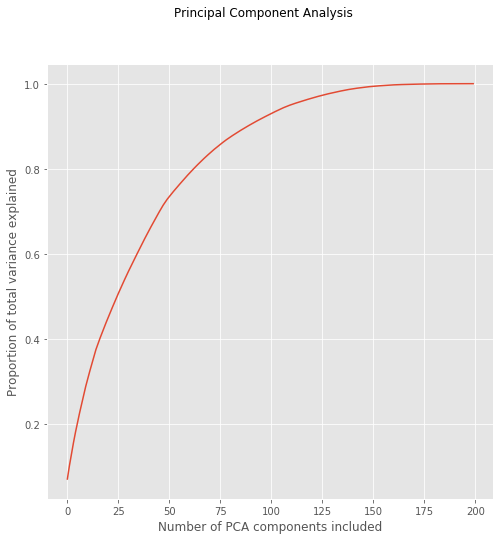

In [26]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Number of PCA components included")
ax.set_ylabel("Proportion of total variance explained")
fig.suptitle("Principal Component Analysis")
ax.plot(total_explained);

In [27]:
for fraction in [0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.999]:
    components_required = 200 - (total_explained > fraction).sum()
    display(Markdown(f"* **{components_required}** principal components required in order to explain **{100 * fraction:.1f}%** of the total variance."))

* **25** principal components required in order to explain **50.0%** of the total variance.

* **53** principal components required in order to explain **75.0%** of the total variance.

* **89** principal components required in order to explain **90.0%** of the total variance.

* **110** principal components required in order to explain **95.0%** of the total variance.

* **127** principal components required in order to explain **97.5%** of the total variance.

* **143** principal components required in order to explain **99.0%** of the total variance.

* **173** principal components required in order to explain **99.9%** of the total variance.

Only 25 principal components are required in order to explain half of the total variance of the feature space, while 143 (less than 75%) are required in order to explain 99% of the total variance.
It might be worth investigating the possibility of using PCA for feature extraction in models such as logistic regression and so on.

## Correlation matrix

Let's see if we can find any highly correlated feature pairs.
We can start by plotting the correlation matrix.

In [28]:
correlation = train_large[features].corr()

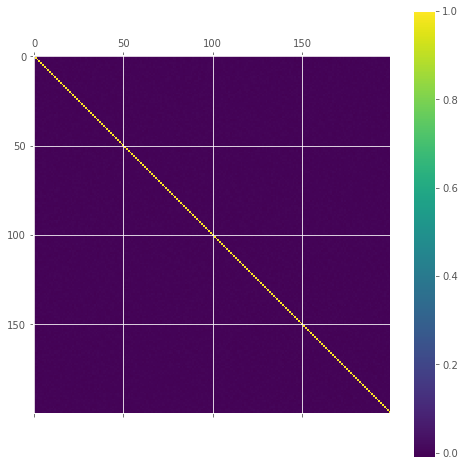

In [29]:
image = plt.matshow(correlation)
plt.colorbar(image);

There is nothing to be gleaned from this plot. Let us try looking at the off-diagonal correlations only, setting the variance diagonal equal to zero.

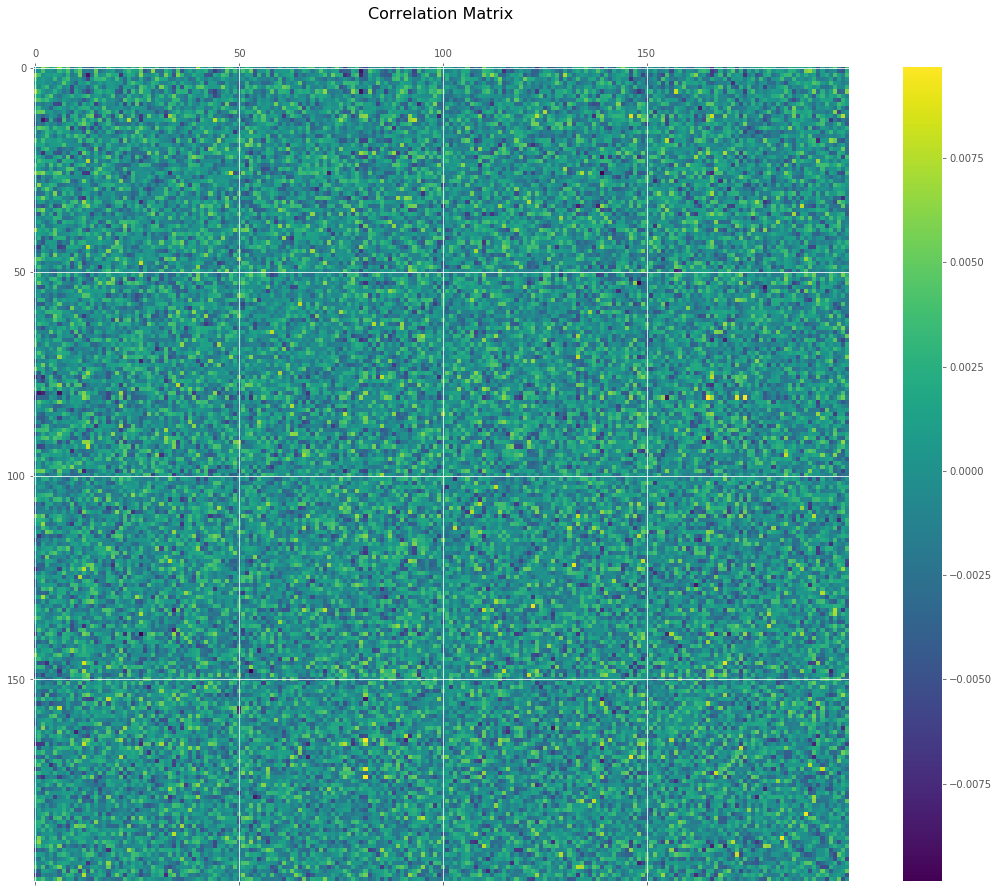

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(19, 15))
c = correlation.copy()
np.fill_diagonal(c.values, 0)
image = ax.matshow(c)
fig.colorbar(image)
plt.title('Correlation Matrix', fontsize=16);

This mainly looks like white noise, and the correlations are neglible.
We will not pursue pairwise correlation further.

## Feature mean distribution

Let's take a look if there is any discernable groupings in the feature means.

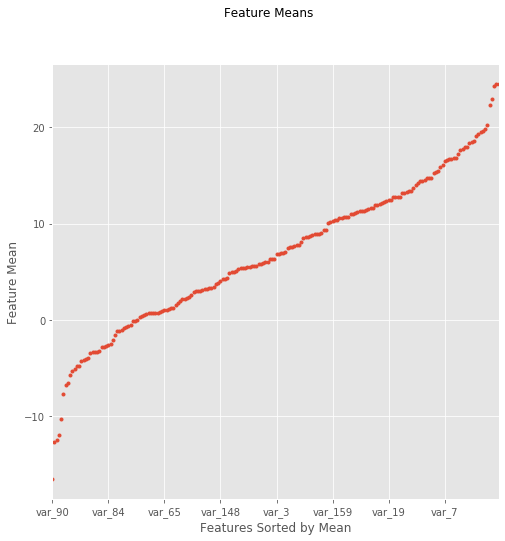

In [31]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Feature Means")
ax.set_xlabel("Features Sorted by Mean")
ax.set_ylabel("Feature Mean")
train_large[features].mean().sort_values().plot(style=".");

No clear groupings in the feature means here, there are some outliers on the edges, but not too many.

## Check if dataset is shuffled

We should make sure that the original dataset is shuffled, and does not contain any discernable trend over the rows.
In order to do this, we will look at the rolling mean of the first 5 features with a window size of 100.

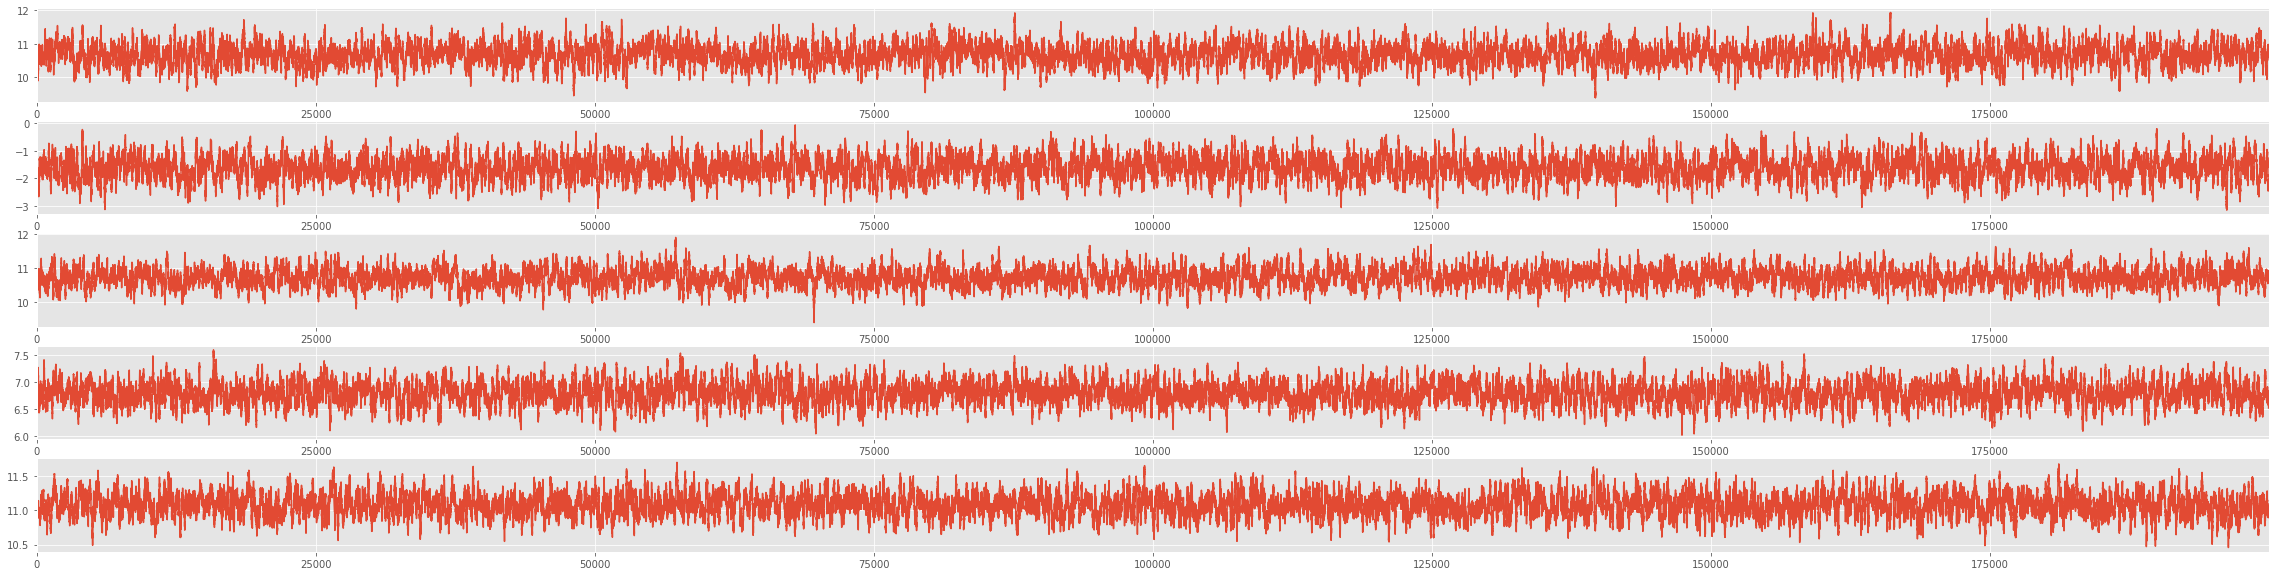

In [32]:
num_features = 5
fig, ax = plt.subplots(num_features, 1, figsize=(40, 2 * num_features))
for feature in range(0, num_features):
    train_large[features[feature]].rolling(100).mean().plot(ax=ax[feature])

Other window sizes and features have been tested, and no trends have been found. These plots have been not included, because they take up a lot of space in this notebook without giving any real insights.

## Feature pairs

Let's plot some feature pairs.
We will look at the first five features paired with the most correlated feature each.

In [33]:
c.idxmax()

var_0        var_6
var_1      var_190
var_2      var_130
var_3      var_114
var_4      var_128
            ...   
var_195     var_18
var_196    var_133
var_197    var_170
var_198     var_12
var_199      var_6
Length: 200, dtype: object

Let's plot these pairings.

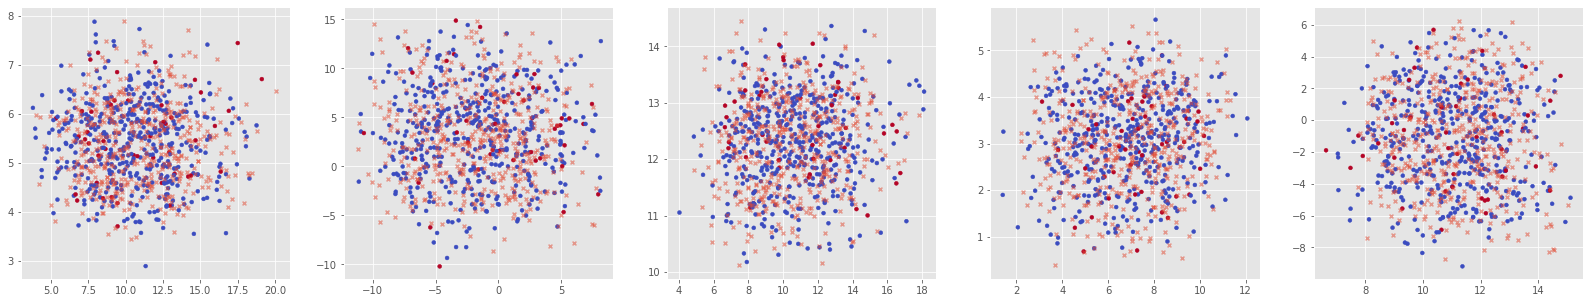

In [34]:
def feature_pairs(feature1, feature2, ax):
    subset = 500
    ax.scatter(
        x=train_large[feature1][0:subset],
        y=train_large[feature2][0:subset],
        c=train_large["target"][0:subset],
        s=15,
        cmap="coolwarm",
    )
    ax.scatter(
        x=test_large[feature1][0:subset],
        y=test_large[feature2][0:subset],
        s=15,
        cmap="orange",
        alpha=0.5,
        marker="x",
    )
    
fig, ax = plt.subplots(1, 5, figsize=(28, 5))
feature_pairs(
    feature1=features[0],
    feature2=features[6],
    ax=ax[0],
)
feature_pairs(
    feature1=features[1],
    feature2=features[190],
    ax=ax[1],
)
feature_pairs(
    feature1=features[2],
    feature2=features[130],
    ax=ax[2],
)
feature_pairs(
    feature1=features[3],
    feature2=features[114],
    ax=ax[3],
)
feature_pairs(
    feature1=features[4],
    feature2=features[128],
    ax=ax[4],
)

The colors indicate the classes, and the crosses are features in the test set.
There is no discernable trend to be found here.

# Implementing a Data Set Wrapper

We have two datasets, one large and one small.
Each of those two datasetes contains one trainig subset _with_ labels, and one test subset _without_ labels.
For the training subsets we will need to split them up in a labeled training, validation, and test subsets in order to perform parameter tuning and model evaluation.

This quickly becomes quite combersome, so we will start by implementing a dataclass wrapper around all these concepts.
The wrapper is implemented below, and we will explain how it works with examples shortly.

In [2]:
import datasets as ds
%psource ds

from collections import namedtuple
from typing import Tuple

from IPython.display import Markdown, display

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

DataSets = namedtuple("DataSets", ["small", "large"])
xy = namedtuple("xy", ["X", "y"])


class DataSet:
    def __init__(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        train_val_test_split: Tuple[float, float, float] = (0.7, 0.15, 0.15),
    ) -> None:
        self._original_train = train
        self._original_test = test
        if train.index.name != "ID_code":
            train = train.set_index("ID_code")
        if test.index.name != "ID_code":
            test = test.set_index("ID_code")
        self.unlabeled_test = xy(X=test, y=None)
        self.all_train =

## Explaining the Data Set Wrapper

We will work with the `datasets` object from now on.
Firstly, it consists of two sub-attributes, `datasets.small` and `datasets.large`, containing the two datasets respectively.

In [3]:
datasets = ds.get_datasets()
print(datasets.small)
print(datasets.large)

The two datasets can be summarized accordingly:

In [4]:
datasets.small.summary()

### DataSet summary

__Train size:__ 70057 __Class balance:__ 90.03% / 10.0%

#### Sub-splits

__Train, validation, test split__ = (0.7, 0.15, 0.15)

__Train split size:__ 49039 __Class balance:__ 90.03% / 10.0%

__Validation split size:__ 10509 __Class balance:__ 90.03% / 10.0%

__Test split size:__ 10509 __Class balance:__ 90.03% / 10.0%

In [5]:
datasets.large.summary()

### DataSet summary

__Train size:__ 200000 __Class balance:__ 89.95% / 10.0%

#### Sub-splits

__Train, validation, test split__ = (0.7, 0.15, 0.15)

__Train split size:__ 140000 __Class balance:__ 89.95% / 10.0%

__Validation split size:__ 30000 __Class balance:__ 89.95% / 10.1%

__Test split size:__ 30000 __Class balance:__ 89.95% / 10.0%

We can observe that the dataset has split up the labeled training datasets into stratified training-, validation-, and test-subsets, with a 70%, 15%, 15% split respectively.
If we want to change the split fractions, let's say setting 90% train, 10% test, and no validation set at all, this can be done with the `resplit()` method which returns a new `DataSet` object.

In [39]:
datasets.small.resplit(0.9, 0, 0.1).summary()

### DataSet summary

__Train size:__ 70057 __Class balance:__ 90.03% / 10.0%

#### Sub-splits

__Train, validation, test split__ = (0.9, 0, 0.1)

__Train split size:__ 63051 __Class balance:__ 90.03% / 10.0%

__Test split size:__ 7006 __Class balance:__ 90.02% / 10.0%

Each dataset have the following attributes:

* `all_train` - All the labeled data for the given dataset, without it being split up into any sub-components.
* `unlabeled_test` - All the unlabeled test data for the given dataset, i.e. only features and no targets.
* `train_split` - A subset of the labeled training data, by defualt a stratified 70% subset of the data.
* `val_split` - A subset of the labeled training data, by defualt a stratified 15% subset of the data.
* `test_split` - A subset of the labeled training data, by defualt a stratified 15% subset of the data.

Each of these attributes have an `X` attribute, containing a feature `DataFrame`, and a `y` attribute, containing the `target` value as a `DataFrame`.
The `y` attribute is `None` for for `unlabeled_test`.

If we have trained a model using `train_split`, we can easily evaluate the resulting model predictions with the `evaluate()` `DataSet` method (which uses the `test_split` under the hood).
Let's see this in practice on a set of random predictions.

### Evaluation Report

__PRC AUC Score:__ 0.10213

__ROC AUC Score:__ 0.50137



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 49.95%

__Balanced Accuracy:__ 49.76%


__Sensitivity:__ 49.52%

__Specificity:__ 49.99%

__Class 1 Precision:__ 9.89%

__Class 1 Recall:__ 49.52%

,Condition Positive,Condition Negative
Positive Prediction,519,4731
Negative Prediction,529,4730


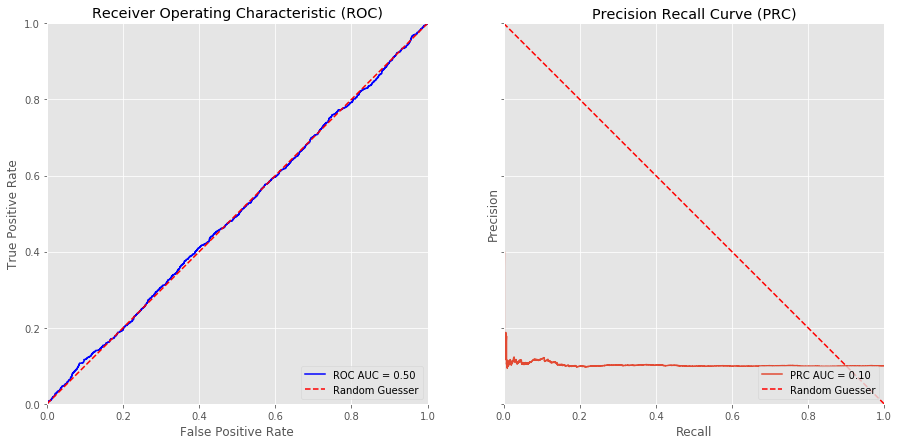

In [40]:
predictions = np.random.uniform(size=datasets.small.test_split.y.size)
datasets.small.evaluate(predictions, plot_roc=True)

We will be using this class going forwards, using `DataSet.evaluate()` in order to check our model fits.
It is the **AUC Score** which is of the greatest importance, since this is the evaluation metric used by the original Kaggle competition.

# Model Fitting Using Raw Data

We will start by fitting a few models on the raw data without any hyperparameter tuning in order to find out which models types are promising for further investigation.

## Naive Bayes

We will implement a naive bayes method.

The naive bayes Classifier comes from Bayes theorem 
\begin{equation*}
 P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})},
\end{equation*}
which means that we can find the probability for classification $\mathbf{y}$ based on the features $\mathbf{X}$. The naive part of this classifier is the assumptions that the features are independent i.e. $P(\mathbf{x}_i,\mathbf{x}_j) = P(\mathbf{x}_i)P(\mathbf{x}_j)$.
The features are contained in the vector $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2,\dots,\mathbf{x}_{200})$ and thereby we can rewrite bayes theorem to 
\begin{equation*}
 P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{x}_1|\mathbf{y})P(\mathbf{x}_2|\mathbf{y})\dots P(\mathbf{x}_{200}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{x}_1)P(\mathbf{x}_2)\dots P(\mathbf{x}_{200})}.
\end{equation*}
The denominator in this is constant and we can rewrite the expression to
\begin{equation*}
P(\mathbf{y}|\mathbf{X}) \propto P(\mathbf{y}) \prod\limits_{i = 1}^{200} P(\mathbf{x}_i|\mathbf{y}),
\end{equation*}
thereby yielding the classifier 
\begin{equation*}
    y = \underset{y}{\mathrm{argmax}} P(y) \prod\limits_{i = 1}^{200} P(\mathbf{x}_i|y).
\end{equation*}

Furthermore we need to define the prior $P(y)$ and the likelihood $P(\mathbf{X}_i|y)$. Our prior belief about $y$ would be the distribution of class $1$ or $0$ labels, which is yields the bernoulli distribution $P(y = 1) \approx 0.1$ and $P(y = 0) \approx 0.9$. 
The choice of likelihood functions is done by looking at the distributions of $\mathbf{X}_i|y = j$. Below we import the dataset with a train/test = $0.75/0.25$, and then we visualize the distribution of 'var_3'.

In [13]:
def plt_density(df, var):
    plt.figure(figsize = (10,10))
    sns.distplot(df.X.loc[df.y == 0,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 0")
    sns.distplot(df.X.loc[df.y == 1,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 1")

    plt.title('Density Plot of ' + var)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

In [14]:
from sklearn.naive_bayes import GaussianNB
data = datasets.small.resplit(0.75, 0.0, 0.25)
gnb = GaussianNB(priors=[0.9, 0.1])
gnb_model = gnb.fit(X=data.train_split.X, y=data.train_split.y)

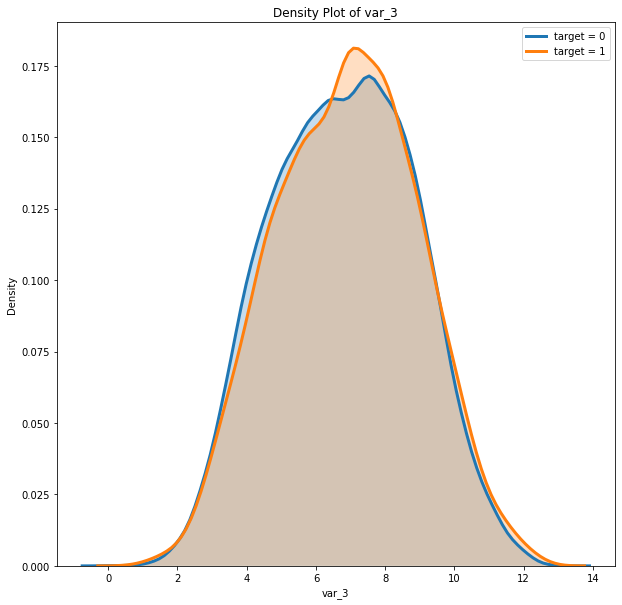

In [15]:
plt_density(data.train_split, 'var_3')

As seen see the the distribution above  is has some similarities with the Gaussian distribution. This is not true for all featues, however we make this assumption and set the likelihood to follow the Gaussian distribution given by the equation 
\begin{equation*}
    x_i|y=j \sim \frac{1}{\sqrt{2\pi\sigma_y^2}}\exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right),
\end{equation*}
where $\mu_y = E(x_i|y = j)$ and $\sigma_y^2 = Var(x_i|y = j)$. If you were to manually program this it would be to take the column mean and standard deviation given the target value $y = j$ where $j \in \{0,1\}$. Thereby using these as the parameters in the distribution of the likelihood.

In [16]:
y_pred = gnb_model.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.59541

__ROC AUC Score:__ 0.89251



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 92.41%

__Balanced Accuracy:__ 68.02%


__Sensitivity:__ 37.55%

__Specificity:__ 98.48%

__Class 1 Precision:__ 73.30%

__Class 1 Recall:__ 37.55%

,Condition Positive,Condition Negative
Positive Prediction,656,239
Negative Prediction,1091,15529


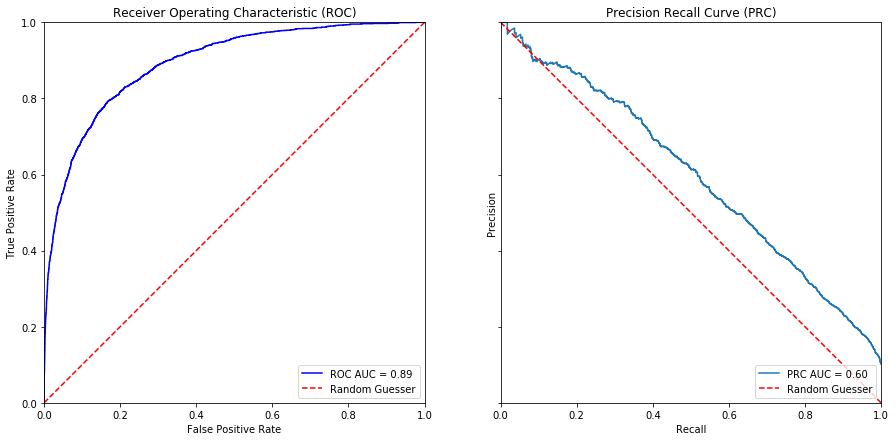

In [18]:
data.evaluate(y_pred,plot_roc = True)

Since the results of the naive bayes classifier is so good, it tells us that the features are close to independent with respect to the target. This is really interesting and means that solution doesn't need to cover the correlation between features for good predictions.


We will use SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset to see if this improves the models prediction on our test set. This method draws lines between features and then samples values on these lines. We will use the default value of five neighbours, which means that the lines are drawn between the five closest points and not between every point in the whole dataset. 

In [19]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(data.train_split.X, data.train_split.y)
print("length of oversampled data is ",len(os_features))
print("Number of 0 labels in oversampled data",len(os_response[os_response==0]))
print("Number of 1 labels",len(os_response[os_response==1]))
print("Proportion of 0 labels in oversampled data is ",len(os_response[os_response==0])/len(os_features))
print("Proportion of 1 labels in oversampled data is ",len(os_response[os_response==1])/len(os_features))

Using TensorFlow backend.


length of oversampled data is  94604
Number of 0 labels in oversampled data 47302
Number of 1 labels 47302
Proportion of 0 labels in oversampled data is  0.5
Proportion of 1 labels in oversampled data is  0.5


Again we will fit a naive bayes classifier for this balanced dataset.

In [20]:
gnb_os = GaussianNB()
gnb_model_os = gnb_os.fit(os_features, os_response)

In [21]:
y_pred = gnb_model_os.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.12831

__ROC AUC Score:__ 0.57966



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 87.12%

__Balanced Accuracy:__ 51.62%


__Sensitivity:__ 7.27%

__Specificity:__ 95.97%

__Class 1 Precision:__ 16.64%

__Class 1 Recall:__ 7.27%

,Condition Positive,Condition Negative
Positive Prediction,127,636
Negative Prediction,1620,15132


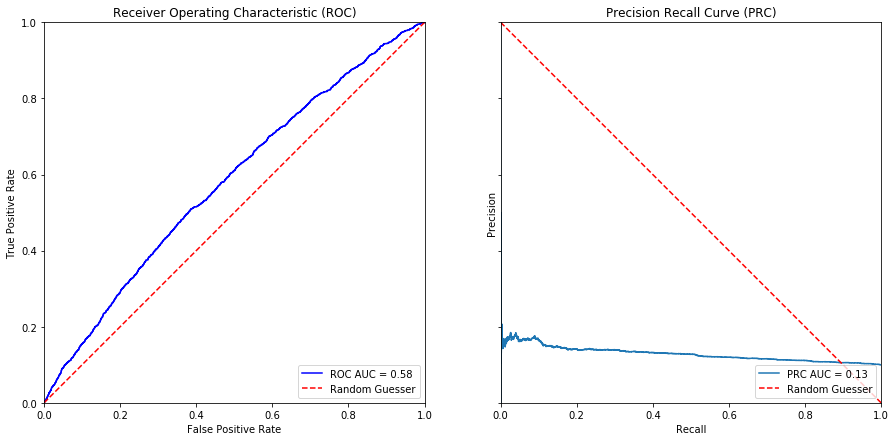

In [22]:
data.evaluate(y_pred,plot_roc = True)

As seen in the figure above, this didn't make any improvements to our model. This is most likely because we have given the features some dependence that didn't exist previously.

## Logistic Regression

Our model consists of 200 features, $x_j$ for $j\in\{1,...,200\}$, and a response $\mathbf{y}$ which has binary values $y \in \{0,1\}$. The response is assumed to follow a Bernoulli distribution s.t. $P(y=1)= p = 1-P(y=0) = 1-q$. We can then write the logarithm of the odds as follows
\begin{equation*}
ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1\mathbf{x_1} + \dots \ \beta_{200}\mathbf{x_{200}},
\end{equation*}
which we can rewrite to
\begin{equation*}
P(y = 1) = \frac{1}{1 + \exp\{-(\beta_0 + \beta_1\mathbf{x_1} + \dots \ \beta_{200}\mathbf{x_{200}})\}} = f(\mathbf{X},\beta).
\end{equation*}
This is the logit function, which squeezes the values between zero and one. Let us now vectorize $\mathbf{\beta}$ and create the design matrix $\mathbf{X}$. We now want to find the maximum likelihood estimates of the $\mathbf{\beta}$s' assuming that the response $\mathbf {y}$ are independently Bernoulli distributed. The log-likelihood function then becomes
\begin{equation*}
l(\mathbf{\beta}|\mathbf{X}) = \sum\limits_{i=1}^{n}ln(P(y_i|\mathbf{x}_i,\mathbf{\beta})) = \sum\limits_{i=1}^n(y_i ln(f(\mathbf{x}_i,\beta) +  (1-y_i)ln(1 - f(\mathbf{x}_i,\beta)).
\end{equation*}
To find the maximum likelihood estimates of $\beta$, a numerical optimization method is used s.t.
\begin{equation*}
\hat{\beta} = \underset{\beta}{\mathrm{argmax}} \enspace l(\beta|\mathbf{X}).
\end{equation*}

### Evaluation Report

__PRC AUC Score:__ 0.51940

__ROC AUC Score:__ 0.86421



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 91.68%

__Balanced Accuracy:__ 63.59%


__Sensitivity:__ 28.51%

__Specificity:__ 98.68%

__Class 1 Precision:__ 70.54%

__Class 1 Recall:__ 28.51%

,Condition Positive,Condition Negative
Positive Prediction,498,208
Negative Prediction,1249,15560


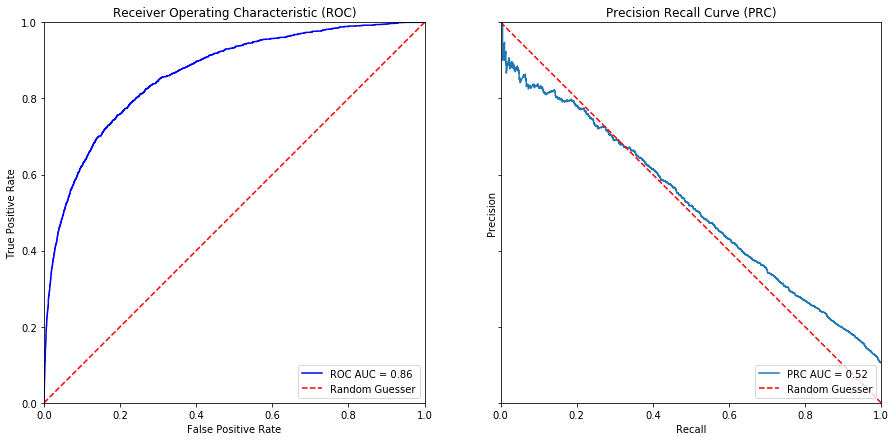

In [23]:
from sklearn.linear_model import LogisticRegression
data = datasets.small.resplit(0.75, 0, 0.25)
logreg = LogisticRegression(solver='lbfgs', max_iter=10_000)
logreg.fit(data.train_split.X, data.train_split.y)
prediction = logreg.predict_proba(data.test_split.X)
data.evaluate(prediction, plot_roc=True)

The logistic regression is really good at predicting negatives, but not at all good at predicting positives. Again we will try to use SMOTE to see if we can improve the prediction of positives.

In [25]:
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(data.train_split.X, data.train_split.y)
print("length of oversampled data is ",len(os_features))
print("Number of 0 labels in oversampled data",len(os_response[os_response==0]))
print("Number of 1 labels",len(os_response[os_response==1]))
print("Proportion of 0 labels in oversampled data is ",len(os_response[os_response==0])/len(os_features))
print("Proportion of 1 labels in oversampled data is ",len(os_response[os_response==1])/len(os_features))

length of oversampled data is  94604
Number of 0 labels in oversampled data 47302
Number of 1 labels 47302
Proportion of 0 labels in oversampled data is  0.5
Proportion of 1 labels in oversampled data is  0.5


In [26]:
lg_os = LogisticRegression(solver='lbfgs',max_iter = 10000)
lg_os.fit(os_features, os_response)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
y_pred = lg_os.predict_proba(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.51219

__ROC AUC Score:__ 0.86071



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 78.44%

__Balanced Accuracy:__ 78.00%


__Sensitivity:__ 77.45%

__Specificity:__ 78.55%

__Class 1 Precision:__ 28.57%

__Class 1 Recall:__ 77.45%

,Condition Positive,Condition Negative
Positive Prediction,1353,3383
Negative Prediction,394,12385


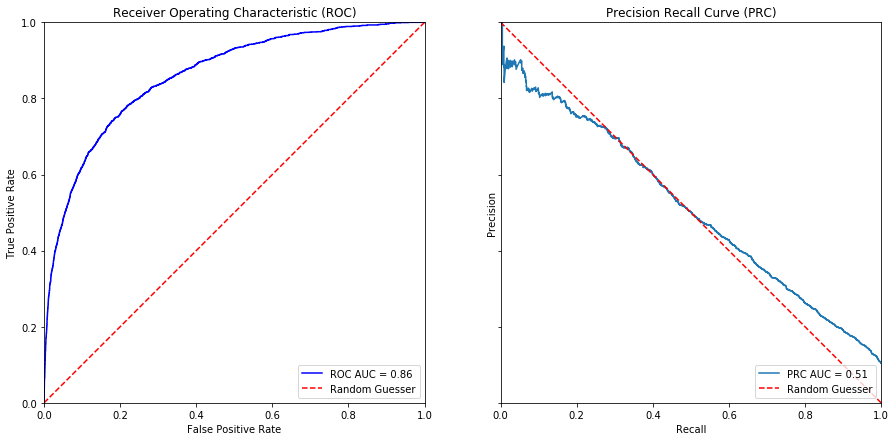

In [28]:
data.evaluate(y_pred,plot_roc = True)

We can see that oversampling improves the prediction of positives by a small amount. And we will now combine this logistic regression model and the naive Bayes classifier.

### Ensamble naive Bayes and over-sampled logstic regression model

There are different methods for doing model ensambles. We will however combine them with linear regression with the probabilities of negatives and postives given by the **.predict_proba** of both models.

In [45]:
data = datasets.small.resplit(0.75, 0, 0.25)
os_features,os_response=os.fit_sample(data.train_split.X, data.train_split.y)
lg_os = LogisticRegression(solver='lbfgs',max_iter = 10000)
lg_os.fit(os_features, os_response)
gnb = GaussianNB(priors=[0.9, 0.1])
gnb_model = gnb.fit(X=data.train_split.X, y=data.train_split.y)

In [46]:
y_pred_lr = lg_os.predict_proba(data.train_split.X)
y_pred_nb = gnb.predict_proba(data.train_split.X)
y_pred_train = np.concatenate([y_pred_lr, y_pred_nb],axis = 1)

In [47]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(y_pred_train, data.train_split.y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Evaluation Report

__PRC AUC Score:__ 0.59548

__ROC AUC Score:__ 0.89283



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 92.41%

__Balanced Accuracy:__ 67.86%


__Sensitivity:__ 37.21%

__Specificity:__ 98.52%

__Class 1 Precision:__ 73.61%

__Class 1 Recall:__ 37.21%

,Condition Positive,Condition Negative
Positive Prediction,650,233
Negative Prediction,1097,15535


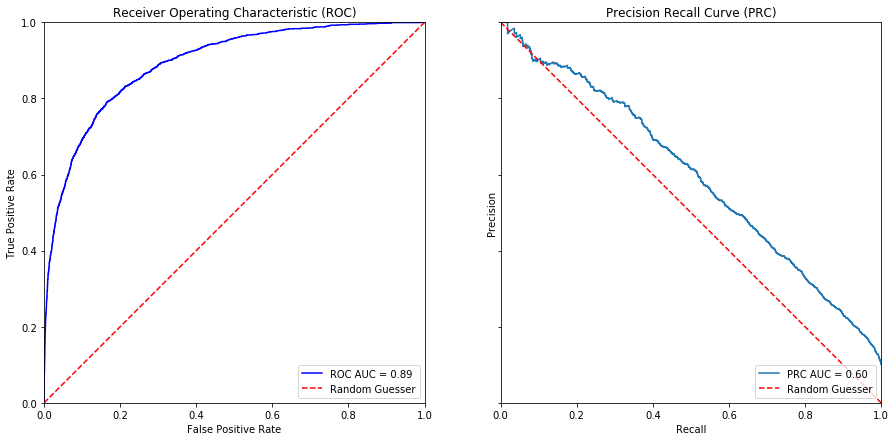

In [48]:
y_pred = regressor.predict(np.concatenate([
    lg_os.predict_proba(data.test_split.X),
    gnb.predict_proba(data.test_split.X)
],axis=1))
data.evaluate(y_pred,plot_roc = True)

This is only a slight improvement from the simple naive Bayes method which yielded  a  AUC$ = 0.89251$. In total we have seen no improvement in using oversampling techniques and the standard naive Bayes with a Gaussian density function yeilds the up to now best results. This is as mentioned earlier because of the independecies in the features. We will now look at more advanced model and look at data engineering to extract interesting features from the data. 

## XGBboost

We now want to fit a *boosted* tree to the data set.
A boosted tree is a sequential learning model that learns by "modifying" itself based on the remaining residuals in each step.
Here is how it works algorithmically:

* Set $\hat{f}^{(0)}(x) = 0$ and $r_i = y_i$ for all $i$ in the training set.
* For $b = 1, 2, ..., B$, repeat:
  * Fit a _new_ $\hat{f}^{(b)}$ with $d$ splits, from the remaining residuals of the previous iteration. This results in $d + 1$ leaf nodes.
  * Update $\hat{f}$ by adding a shrunken down version of this new tree: $$\hat{f} \leftarrow \hat{f} + \lambda \hat{f}^{(b)}$$
  * Update the residuals, $$r_i \leftarrow r_i - \lambda \hat{f}^{(b)}(x_i)$$
* The boosted model is $\hat{f}(x) = \sum_{b = 1}^B \lambda \hat{f}^{(b)}(x)$.

## LightGBM

In [44]:
import lightgbm as lgb

In [45]:
data = datasets.small.resplit(0.7, 0.15, 0.15)
train_data = lgb.Dataset(
    data=data.train_split.X,
    label=data.train_split.y,
)
validation_data = lgb.Dataset(
    data=data.val_split.X,
    label=data.val_split.y,
    reference=train_data,
)

In [46]:
params = {
    "num_leaves": 3,
    "objective": "binary",
    "metric": "auc",
    "seed": 42,
    "device_type": "cpu",
    "num_threads": 24,
    "boosting": "gbdt",
    "learning_rate": 0.001,
    "is_unbalance": True,
    "boost_from_average": False,
    "feature_fraction": 0.04,
}

In [47]:
from pathlib import Path

def train_lgbm(params, num_leaves):
    filepath = Path(f".cache/lgbm/{num_leaves}.model")
    if filepath.exists() and False:
        best_lgbm_model = lgb.Booster(model_file=str(filepath))
        return best_lgbm_model, {}
    
    params = params.copy()
    params["num_leaves"] = num_leaves
    num_round = 100_000_000
    patience = 10_000
    print_every = 10_000
    evals_result = {}
    best_lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=num_round,
        valid_sets=[validation_data],
        verbose_eval=print_every,
        evals_result=evals_result,
        early_stopping_rounds=patience,
    )
    
    filepath.parent.mkdir(exist_ok=True, parents=True)
    best_lgb_model.save_model(str(filepath))
    return best_lgb_model, evals_result

In [48]:
three_leaves, three_leaves_evals = train_lgbm(params=params, num_leaves=3)

Training until validation scores don't improve for 10000 rounds
[10000]	valid_0's auc: 0.84021
[20000]	valid_0's auc: 0.854684
[30000]	valid_0's auc: 0.86735
[40000]	valid_0's auc: 0.876145
[50000]	valid_0's auc: 0.882004
[60000]	valid_0's auc: 0.886048
[70000]	valid_0's auc: 0.889033
[80000]	valid_0's auc: 0.891345
[90000]	valid_0's auc: 0.89315
[100000]	valid_0's auc: 0.894473
[110000]	valid_0's auc: 0.895465
[120000]	valid_0's auc: 0.896214
[130000]	valid_0's auc: 0.896756
[140000]	valid_0's auc: 0.897226
[150000]	valid_0's auc: 0.897551
[160000]	valid_0's auc: 0.897831
[170000]	valid_0's auc: 0.898038
[180000]	valid_0's auc: 0.898208
[190000]	valid_0's auc: 0.89831
[200000]	valid_0's auc: 0.898357
[210000]	valid_0's auc: 0.898374
[220000]	valid_0's auc: 0.898415
[230000]	valid_0's auc: 0.898449
[240000]	valid_0's auc: 0.898475
Early stopping, best iteration is:
[236404]	valid_0's auc: 0.898496


### Evaluation Report

__PRC AUC Score:__ 0.59160

__ROC AUC Score:__ 0.88928



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 85.07%

__Balanced Accuracy:__ 80.51%


__Sensitivity:__ 74.81%

__Specificity:__ 86.21%

__Class 1 Precision:__ 37.53%

__Class 1 Recall:__ 74.81%

,Condition Positive,Condition Negative
Positive Prediction,784,1305
Negative Prediction,264,8156


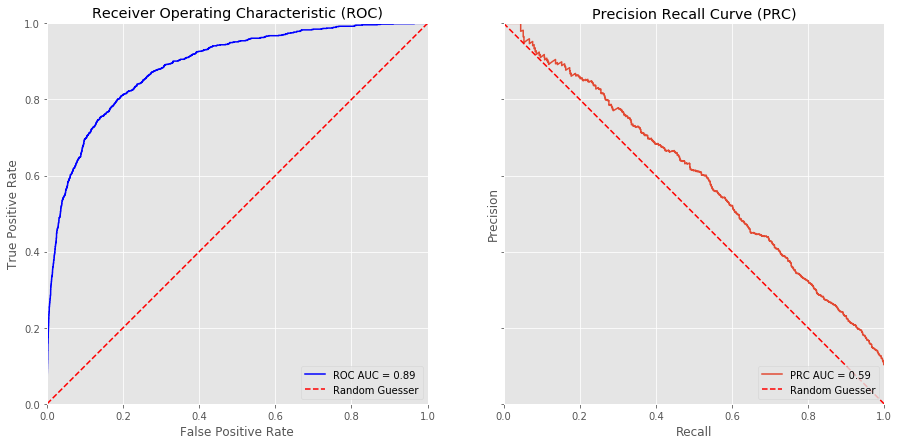

In [49]:
three_leaves_prediction = three_leaves.predict(data.test_split.X)
data.evaluate(three_leaves_prediction)

In [50]:
two_leaves, two_leaves_evals = train_lgbm(params, num_leaves=2)

Training until validation scores don't improve for 10000 rounds
[10000]	valid_0's auc: 0.80055
[20000]	valid_0's auc: 0.82335
[30000]	valid_0's auc: 0.842366
[40000]	valid_0's auc: 0.853982
[50000]	valid_0's auc: 0.862408
[60000]	valid_0's auc: 0.868547
[70000]	valid_0's auc: 0.873386
[80000]	valid_0's auc: 0.877168
[90000]	valid_0's auc: 0.880117
[100000]	valid_0's auc: 0.882618
[110000]	valid_0's auc: 0.884658
[120000]	valid_0's auc: 0.886368
[130000]	valid_0's auc: 0.88796
[140000]	valid_0's auc: 0.889364
[150000]	valid_0's auc: 0.890533
[160000]	valid_0's auc: 0.89156
[170000]	valid_0's auc: 0.892415
[180000]	valid_0's auc: 0.893142
[190000]	valid_0's auc: 0.893789
[200000]	valid_0's auc: 0.894364
[210000]	valid_0's auc: 0.89487
[220000]	valid_0's auc: 0.895321
[230000]	valid_0's auc: 0.895739
[240000]	valid_0's auc: 0.896101
[250000]	valid_0's auc: 0.896412
[260000]	valid_0's auc: 0.896693
[270000]	valid_0's auc: 0.896938
[280000]	valid_0's auc: 0.897142
[290000]	valid_0's auc: 0.

In [51]:
two_leaves_prediction = two_leaves.predict(data.test_split.X)

### Evaluation Report

__PRC AUC Score:__ 0.59086

__ROC AUC Score:__ 0.88933



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 83.38%

__Balanced Accuracy:__ 80.37%


__Sensitivity:__ 76.62%

__Specificity:__ 84.12%

__Class 1 Precision:__ 34.84%

__Class 1 Recall:__ 76.62%

,Condition Positive,Condition Negative
Positive Prediction,803,1502
Negative Prediction,245,7959


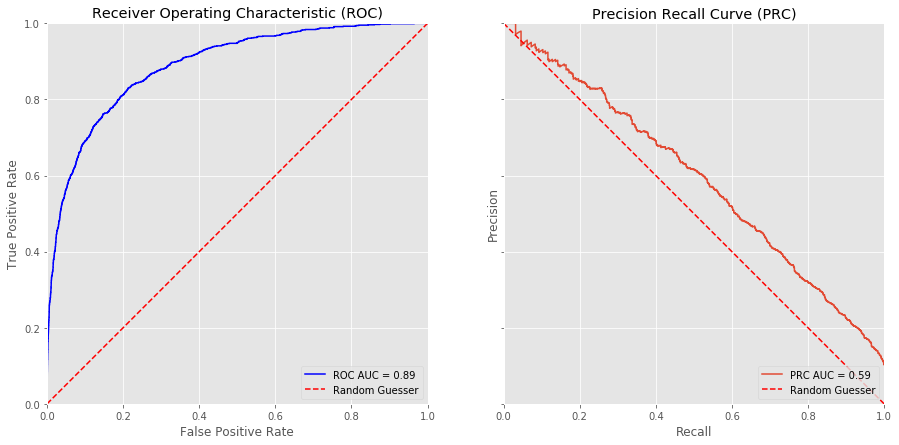

In [52]:
data.evaluate(two_leaves_prediction, plot_roc=True)

# Feature Engineering

We will now perform some feature engineering inspired by the [winning submission](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003#latest-638601). We will construct categorical features, and we will encode them as integere, as recommended by the `LightGBM` documentation, as can be seen here:

> __categorical_feature__ : list of strings or int, or 'auto', optional (default="auto")
>
>   Categorical features.
>
>   If list of int, interpreted as indices.
>   
>   If list of strings, interpreted as feature names (need to specify ``feature_name`` as well).
>   
>   If 'auto' and data is pandas DataFrame, pandas unordered categorical columns are used.
>   
>   All values in categorical features should be less than int32 max value (2147483647).
>   
>   Large values could be memory consuming. Consider using consecutive integers starting from zero.
>   
>   All negative values in categorical features will be treated as missing values.
>   
>   The output cannot be monotonically constrained with respect to a categorical feature.

We construct one additional categorical column for each of the 200 original numerical raw features.
The following categories will be defined:

* __0 = "zero target"__ The given feature is non-unique and all other rows with this feature value has train target equal to 0.
* __1 = "one target"__ The given feature is non-unique and all other rows with this feature value has train target equal to 1.
* __2 = "mixed target"__ The given feature is non-unique and the rows with this feature value has mixed target values of both 0 and 1.
* __3 = "train unique"__ The given feature value is unique in the training set, but not in the train **and** test set.
* __4 = "totally unique"__ The given feature value is unique in the training set **and** the test set.

This feature engineering algorithm is implemented in `feature_engineering.categorical_feature` and the source code is shown below:

In [53]:
from feature_engineering import categorical_feature
%psource categorical_feature

def categorical_feature(args):
    feature_name, rows, train_rows, test_rows, train_targets, is_train = args
    new_column = []

    for index, row in enumerate(rows):
        matches = (train_rows == row)
        if is_train:
            matches[index] = False
        unique_in_train = not matches.any()
        if unique_in_train:
            unique_in_test = row in test_rows
            if unique_in_test:
                new_column.append(4)
            else:
                new_column.append(3)
            continue
        targets = train_targets[matches]
        contains_zeros = 0 in targets
        contains_ones = 1 in targets
        if contains_zeros and contains_ones:
            new_column.append(2)
        elif contains_zeros:
            new_column.append(0)
        elif contains_ones:
            new_column.append(1)
        else:
            raise RuntimeError("Should never reach this point!")

    return (
        feature_name + "_categorical",
        pd.Categorical(
  

We will now implement a function which applies this algorithm to a given dataset.
We will use `multiprocessing.Pool` in order to do this in parallel, and the reason for `categorical_feature` being implemented in a separate module instead of just being inlined in this notebook, is that multiprocessing functions defined in Jupyter Notebook is not supported.

In [54]:
from multiprocessing import Pool

def categorical_uniqueness(dataset):
    train = dataset.all_train
    test = dataset.unlabeled_test
    
    train_iterable = zip(
        train.X.columns,
        train.X.to_numpy().T,
        train.X.to_numpy().T,
        test.X.to_numpy().T,
        [train.y.to_numpy()] * 200,
        [True] * 200,
    )
    pool = Pool()
    new_train_columns = {}
    for result in pool.imap(categorical_feature, train_iterable):
        print(f"Finished processing: {result[0]} (TRAIN)", end="\r")
        new_train_columns[result[0]] = result[1]
        
    test_iterable = zip(
        train.X.columns,
        test.X.to_numpy().T,
        train.X.to_numpy().T,
        test.X.to_numpy().T,
        [train.y.to_numpy()] * 200,
        [False] * 200,
    )
    pool = Pool()
    new_test_columns = {}
    for result in pool.imap(categorical_feature, test_iterable):
        print(f"Finished processing: {result[0]} (TEST)", end="\r")
        new_test_columns[result[0]] = result[1]
        
    return (
        pd.DataFrame.from_dict(new_train_columns),
        pd.DataFrame.from_dict(new_test_columns),
    )

We will now construct these categorical features for the _small train and test sets_.

In [ ]:
categorical_train_columns, categorical_test_columns = (
    categorical_uniqueness(dataset=datasets.small)
)

Just to make sure, we will cast this columns to the unordered `category` dtype, since `lightgbm` will automatically infer that it should handle these columns as categorical features.

In [56]:
categorical_type = pd.CategoricalDtype(
    categories=[0, 1, 2, 3, 4],
    ordered=False,
)

categorical_train_columns = categorical_train_columns.astype(categorical_type)
categorical_test_columns = categorical_test_columns.astype(categorical_type)

We will now concatenate these new columns with the original raw features, and construct a new `DataSet` wrapper with all these features.

In [57]:
new_train = train_small.copy()
for column_name in categorical_train_columns.columns:
    new_train[column_name] = categorical_train_columns[column_name]

new_test = test_small.copy()
for column_name in categorical_test_columns.columns:
    new_test[column_name] = categorical_test_columns[column_name]
    
engineered_dataset = ds.DataSet(train=new_train, test=new_test)

Let's check if the new covariates are indeed categorical.

In [58]:
engineered_dataset.all_train.X["var_0_categorical"]

ID_code
train_1         4
train_2         0
train_4         0
train_5         3
train_6         0
               ..
train_199983    0
train_199987    4
train_199993    3
train_199996    4
train_199998    4
Name: var_0_categorical, Length: 70057, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]

Yes, it is! We should have 400 covariates all together now.

In [59]:
engineered_dataset.all_train.X.shape

(70057, 400)

In [60]:
import lightgbm as lgb

numeric_features = [f"var_{index}" for index in range(0, 200)]
categorical_features = [f"var_{index}_categorical" for index in range(0, 200)]
all_features = numeric_features + categorical_features

data = engineered_dataset.resplit(0.7, 0.15, 0.15)
engineered_train_data = lgb.Dataset(
    data=data.train_split.X,
    label=data.train_split.y,
    feature_name=all_features,
    categorical_feature=categorical_features,
)
engineered_validation_data = lgb.Dataset(
    data=data.val_split.X,
    label=data.val_split.y,
    reference=train_data,
    feature_name=all_features,
    categorical_feature=categorical_features,
)

In [90]:
from pathlib import Path

def train_engineered_lgbm(params, num_leaves):
    filepath = Path(f".cache/lgbm/{num_leaves}_engineered.model")
    if filepath.exists() and False:
        best_lgbm_model = lgb.Booster(model_file=str(filepath))
        return best_lgbm_model, {}
    
    params = params.copy()
    engineered_params["num_leaves"] = num_leaves
    num_round = 100_000_000
    patience = 5_000
    print_every = 5000
    evals_result = {}
    best_lgb_model = lgb.train(
        params=engineered_params,
        train_set=engineered_train_data,
        num_boost_round=num_round,
        valid_sets=[engineered_validation_data],
        verbose_eval=print_every,
        evals_result=evals_result,
        early_stopping_rounds=patience,
        feature_name=all_features,
        categorical_feature=categorical_features,
    )
    
    filepath.parent.mkdir(exist_ok=True, parents=True)
    best_lgb_model.save_model(str(filepath))
    return best_lgb_model, evals_result

In [94]:
engineered_params = params.copy()
engineered_params["learning_rate"] = 0.007
# 14, 90451
engineered_lgb_model, evals = train_engineered_lgbm(params=engineered_params, num_leaves=14)

Training until validation scores don't improve for 5000 rounds
[5000]	valid_0's auc: 0.898046
[10000]	valid_0's auc: 0.89966
[15000]	valid_0's auc: 0.899347
Early stopping, best iteration is:
[10832]	valid_0's auc: 0.899889


### Evaluation Report

__PRC AUC Score:__ 0.63450

__ROC AUC Score:__ 0.90438



_Following statistics calculated with cut-off = 0.5_

__Accuracy:__ 89.79%

__Balanced Accuracy:__ 80.21%


__Sensitivity:__ 68.24%

__Specificity:__ 92.18%

__Class 1 Precision:__ 49.18%

__Class 1 Recall:__ 68.24%

,Condition Positive,Condition Negative
Positive Prediction,477,493
Negative Prediction,222,5814


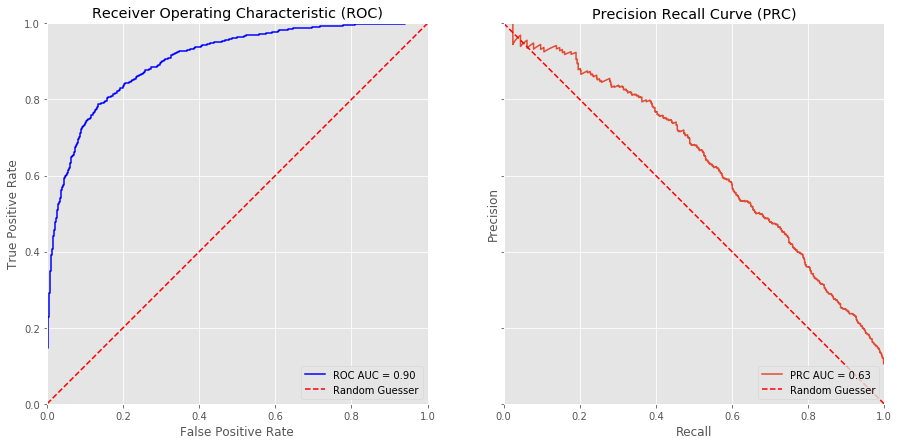

In [95]:
prediction = engineered_lgb_model.predict(data.test_split.X)
data.evaluate(prediction)

In [96]:
from test import evaluate
p = engineered_lgb_model.predict(data.unlabeled_test.X)
evaluate(p)

Accuracy: 89.23000071362306%
Confusion matrix:
[[58106  4889]
 [ 2657  4413]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     62995
           1       0.47      0.62      0.54      7070

    accuracy                           0.89     70065
   macro avg       0.72      0.77      0.74     70065
weighted avg       0.91      0.89      0.90     70065

AUC:
0.8886452293591474
